
# San Francisco Rent Trends — Final Analysis Notebook

**Author:** Luke Drury  
**Course:** UC Berkeley Exec Ed ML/AI — Capstone  
**Last updated:** 2025-10-07

- Runs top‑to‑bottom with no manual edits (assuming inputs exist under `./data/`).
- Produces clean plots and metrics.
- **Writes** a `README_FINAL.md` at the end, inserting the metrics you just computed.

> If any input is missing, the notebook will raise a clear, actionable error telling you what's needed.


In [1]:

# Standard imports and formatting
import os, sys, json, math, warnings
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

pd.set_option('display.max_colwidth', 120)
pd.set_option('display.float_format', lambda x: f'{x:,.3f}')
plt.rcParams['figure.dpi'] = 120
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['axes.labelsize'] = 10

# Modeling
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import GridSearchCV, KFold

# Geo (optional; used only if you choose to map)
try:
    import geopandas as gpd
    GEO_OK = True
except Exception as e:
    GEO_OK = False
    print("Geo libraries not available; maps will be skipped.", e)


In [2]:

# Paths and expected inputs
from pathlib import Path
DATA_DIR = Path('.')
FILES_REQUIRED = {
    'zori_zip.csv': 'Zillow Observed Rent Index by ZIP (wide or long)',
    'sf_zip_codes.geojson': 'SF ZIP polygons (for optional maps)',
    'muni_stops.csv': 'SFMTA stops (for transit density)',
    'airbnb_sf_listings.csv': 'Inside Airbnb listings (for density)'
}
FILES_OPTIONAL = ['sfpd_incidents.csv','income_zip.csv']

missing = [f for f in FILES_REQUIRED if not (DATA_DIR / f).exists()]
if missing:
    raise FileNotFoundError(
        "Missing required input(s):\n- " + "\n- ".join(missing) +
        "\nPlace them under ./data/ with these exact filenames."
    )
else:
    print("All required inputs found in ./data")


All required inputs found in ./data


In [3]:

# Helper functions
import pandas as pd, numpy as np
def safe_read_csv(path, parse_dates=None):
    try:
        return pd.read_csv(path, parse_dates=parse_dates)
    except Exception as e:
        raise RuntimeError(f"Failed to read {path}: {e}")

def standardize_zip(series):
    return series.astype(str).str.extract(r'(\d{5})')[0]

def get_zip_series(df, candidates=('zip','zipcode','Zip','ZIP','postal_code','PostalCode')):
    """Return a Series from the first existing candidate column; else a NaN Series."""
    for c in candidates:
        if c in df.columns:
            return df[c]
    # fall back: return a NaN series aligned to df
    return pd.Series(np.nan, index=df.index)

def standardize_zip(x):
    """
    Accepts Series/array-like/string; returns a Series of 5-digit ZIPs or NaN.
    """
    if isinstance(x, pd.Series):
        s = x.astype(str)
    else:
        # wrap scalars/arrays into Series so .astype/.str works uniformly
        s = pd.Series(x)
        s = s.astype(str)
    return s.str.extract(r'(\d{5})')[0]

    # --- put near your helpers ---
def normalize_zip_col(df, col='zip'):
    """Ensure 'zip' is a string of 5 digits; drop rows with missing zip."""
    out = df.copy()
    # if the column isn't present, create it full of NA so downstream drops it
    if col not in out.columns:
        out[col] = pd.NA
    # standardize and force string dtype
    out[col] = standardize_zip(out[col]).astype('string')
    # drop NAs so groupby artifacts like all-NaN don't create float dtypes
    out = out.dropna(subset=[col])
    return out



# Load core datasets
zori = safe_read_csv(DATA_DIR / 'zori_zip.csv')
zip_geo_path = DATA_DIR / 'sf_zip_codes.geojson'
try:
    import geopandas as gpd
    zip_geo = gpd.read_file(zip_geo_path) if zip_geo_path.exists() else None
except Exception:
    zip_geo = None

muni = safe_read_csv(DATA_DIR / 'muni_stops.csv')
airbnb = safe_read_csv(DATA_DIR / 'airbnb_sf_listings.csv')

# Optional
sfpd = (
    pd.read_csv(DATA_DIR / 'sfpd_incidents.csv', nrows=14379) 
    if (DATA_DIR / 'sfpd_incidents.csv').exists() else None
)
income = safe_read_csv(DATA_DIR / 'income_zip.csv') if (DATA_DIR / 'income_zip.csv').exists() else None

print("Loaded shapes:", {k: v.shape for k,v in [('zori',zori),('muni',muni),('airbnb',airbnb)]})


Loaded shapes: {'zori': (4829, 136), 'muni': (3264, 21), 'airbnb': (7804, 18)}


In [4]:

# Normalize ZORI to long format: ['zip','date','zori']
if {'RegionName','Date','ZORI'}.issubset(set(zori.columns)):
    zori_long = zori.rename(columns={'RegionName':'zip','Date':'date','ZORI':'zori'})
elif 'RegionName' in zori.columns:
    id_col = 'RegionName'
    value_cols = [c for c in zori.columns if c != id_col]
    zori_long = zori.melt(id_vars=[id_col], value_vars=value_cols, var_name='date', value_name='zori')
    zori_long = zori_long.rename(columns={'RegionName':'zip'})
else:
    zori_long = zori.copy()

zori_long['zip'] = standardize_zip(zori_long['zip'])
zori_long['date'] = pd.to_datetime(zori_long['date'], errors='coerce')
zori_long = zori_long.dropna(subset=['zip','date','zori']).sort_values(['zip','date']).reset_index(drop=True)

latest_date = zori_long['date'].max()
zori_latest = zori_long[zori_long['date']==latest_date].rename(columns={'zori':'rent_index'}).copy()
print("ZORI range:", zori_long['date'].min().date(), "→", latest_date.date(), "| ZIPs:", zori_latest['zip'].nunique())


ZORI range: 2015-01-31 → 2025-07-31 | ZIPs: 4519


In [5]:
# ===================== ZIP alignment & spatial joins =====================

import os, requests
import pandas as pd, numpy as np

# ---------- tiny guards if helpers weren't defined above ----------
if 'get_zip_series' not in globals():
    def get_zip_series(df, candidates=('zip','zipcode','Zip','ZIP','postal_code','PostalCode','ZCTA','ZCTA5CE10')):
        for c in candidates:
            if c in df.columns:
                return df[c]
        return pd.Series(np.nan, index=df.index)

if 'standardize_zip' not in globals():
    def standardize_zip(x):
        s = x if isinstance(x, pd.Series) else pd.Series(x)
        return s.astype(str).str.extract(r'(\d{5})')[0]

# ---------- COORD HELPERS ----------
from typing import Optional, Tuple

def detect_latlon_cols(df) -> Tuple[Optional[str], Optional[str]]:
    """Return (lat_col, lon_col) among many variants; else (None, None)."""
    candidates = [
        ('latitude','longitude'), ('Latitude','Longitude'),
        ('LATITUDE','LONGITUDE'),            # <-- your Muni file
        ('lat','lon'), ('lat','lng'), ('LAT','LON'),
        ('y','x'), ('Y','X'),
        ('stop_lat','stop_lon'), ('STOP_LAT','STOP_LON'),
        ('stop_latitude','stop_longitude'),
        ('latitude_deg','longitude_deg')
    ]
    cols = set(df.columns)
    for la, lo in candidates:
        if la in cols and lo in cols:
            return la, lo
    return None, None

def make_points_wgs84(df):
    """
    Build a GeoDataFrame of points in EPSG:4326 (WGS84) from df.
    - Prefer lat/lon in degrees; else try x/y meters (EPSG:3857) and convert.
    """
    try:
        import geopandas as gpd
        from shapely.geometry import Point
    except Exception as e:
        print("Geo dependencies missing:", e)
        return None

    la, lo = detect_latlon_cols(df)
    if la and lo:
        lat = pd.to_numeric(df[la], errors='coerce')
        lon = pd.to_numeric(df[lo], errors='coerce')
        plausible_deg = lat.between(37, 38).any() and lon.between(-123, -122).any()
        if plausible_deg:
            return gpd.GeoDataFrame(
                df[[la, lo]].copy(),
                geometry=[Point(xy) for xy in zip(lon, lat)],
                crs="EPSG:4326"
            )

    # try projected x/y meters → EPSG:3857
    for xcol, ycol in [('x','y'), ('X','Y'), ('lon','lat'), ('LON','LAT')]:
        if xcol in df.columns and ycol in df.columns:
            x = pd.to_numeric(df[xcol], errors='coerce')
            y = pd.to_numeric(df[ycol], errors='coerce')
            if (x.abs().gt(1000).any() and y.abs().gt(1000).any()):
                import geopandas as gpd
                from shapely.geometry import Point
                gpts_m = gpd.GeoDataFrame(
                    df[[xcol, ycol]].copy(),
                    geometry=[Point(xy) for xy in zip(x, y)],
                    crs="EPSG:3857"
                )
                try:
                    return gpts_m.to_crs("EPSG:4326")
                except Exception as e:
                    print("CRS transform failed:", e)
    return None

def points_to_zip_wgs84(gpts, zpoly):
    """Join points (EPSG:4326) to ZIP polygons: within → intersects → nearest(100m)."""
    import geopandas as gpd
    z = zpoly.copy()
    if 'zip' not in z.columns:
        z['zip'] = standardize_zip(get_zip_series(z, candidates=('ZCTA5CE10','zip','zipcode'))).astype('string')
    try:
        z = z.set_crs('EPSG:4326', allow_override=True).to_crs('EPSG:4326')
    except Exception:
        pass

    joined = gpd.sjoin(gpts, z[['zip','geometry']], how='left', predicate='within')
    if joined['zip'].notna().any():
        return joined['zip'].astype('string').reset_index(drop=True)

    joined = gpd.sjoin(gpts, z[['zip','geometry']], how='left', predicate='intersects')
    if joined['zip'].notna().any():
        return joined['zip'].astype('string').reset_index(drop=True)

    z_m = z.to_crs("EPSG:3857")
    g_m = gpts.to_crs("EPSG:3857")
    joined = gpd.sjoin_nearest(g_m, z_m[['zip','geometry']], how='left', max_distance=100)
    return joined['zip'].astype('string').reset_index(drop=True)

def normalize_zip_col(df, col='zip'):
    out = df.copy()
    if col not in out.columns:
        out[col] = pd.NA
    out[col] = standardize_zip(out[col]).astype('string')
    out = out.dropna(subset=[col])
    return out

# ---------- ACS income via Census API ----------
def get_acs_income_zip(sf_zips, year=2023, api_key=None, verbose=False):
    """
    Fetch median household income by ZCTA (ZIP) for given zips.
    Tries ACS 5-year SUBJECT S1901 first, then DETAILED B19013_001E.
    Returns DataFrame ['ZIP','median_income'].
    """
    attempts = [
        (f"https://api.census.gov/data/{year}/acs/acs5/subject",  "S1901_C01_012E", "S1901 subject (5yr)"),
        (f"https://api.census.gov/data/{year}/acs/acs5",          "B19013_001E",    "B19013 detailed (5yr)"),
    ]

    def call_endpoint(base_url, var, zips_chunk):
        params = {"get": f"NAME,{var}", "for": f"zip code tabulation area:{','.join(zips_chunk)}"}
        if api_key:
            params["key"] = api_key
        r = requests.get(base_url, params=params, timeout=30)
        r.raise_for_status()
        data = r.json()
        cols, vals = data[0], data[1:]
        df = pd.DataFrame(vals, columns=cols)
        df = df.rename(columns={"zip code tabulation area": "ZIP", var: "median_income"})[["ZIP","median_income"]]
        df["ZIP"] = df["ZIP"].astype(str).str.zfill(5)
        df["median_income"] = pd.to_numeric(df["median_income"], errors="coerce")
        return df

    chunks = [sf_zips[i:i+50] for i in range(0, len(sf_zips), 50)]
    frames = []

    for base, var, label in attempts:
        frames = []
        try:
            for ch in chunks:
                frames.append(call_endpoint(base, var, ch))
            out = pd.concat(frames, ignore_index=True)
            if verbose:
                print(f"ACS income fetched using {label}: {len(out)} rows")
            return out
        except Exception as e:
            if verbose:
                print(f"Attempt {label} failed: {e}")

    # if both attempts failed
    return pd.DataFrame(columns=["ZIP","median_income"])

# ---------- Build SF zip set from polygons ----------
zgeo = zip_geo.copy()
zgeo['zip'] = standardize_zip(get_zip_series(zgeo, candidates=('ZCTA5CE10','zip','zipcode'))).astype('string')
sf_zips = sorted(zgeo['zip'].dropna().unique().tolist())

# -------------------- 1) Filter ZORI to SF ZIPs --------------------
zori_latest = zori_latest.copy()
zori_latest['zip'] = standardize_zip(zori_latest['zip']).astype('string')
zori_latest = zori_latest[zori_latest['zip'].isin(sf_zips)]
if zori_latest.empty:
    raise RuntimeError("After filtering, zori_latest has no SF ZIPs. Confirm ZORI contains 941xx ZCTAs.")

# -------------------- 2) Transit via spatial join --------------------
gpts_muni = make_points_wgs84(muni)
if gpts_muni is not None:
    muni_zip_series = points_to_zip_wgs84(gpts_muni, zgeo)
else:
    muni_zip_series = standardize_zip(get_zip_series(muni, candidates=('zip','zipcode','ZCTA','ZCTA5CE10'))).astype('string')

transit_density = (
    pd.DataFrame({'zip': muni_zip_series})
      .dropna(subset=['zip'])
      .groupby('zip', as_index=False).size()
      .rename(columns={'size':'transit_count'})
)

# -------------------- 3) Airbnb ZIPs (spatial join, robust) --------------------
gpts_airbnb = make_points_wgs84(airbnb)
if gpts_airbnb is not None:
    airbnb_zip_series = points_to_zip_wgs84(gpts_airbnb, zgeo)
else:
    airbnb_zip_series = standardize_zip(get_zip_series(airbnb, candidates=('zip','zipcode','ZCTA','ZCTA5CE10'))).astype('string')

airbnb_counts = (
    pd.DataFrame({'zip': airbnb_zip_series})
      .dropna(subset=['zip'])
      .groupby('zip', as_index=False).size()
      .rename(columns={'size':'airbnb_count'})
)

# -------------------- 4) Income via Census API for SF ZCTAs --------------------
CENSUS_API_KEY = os.getenv("CENSUS_API_KEY", None)
acs = get_acs_income_zip(sf_zips, year=2023, api_key=CENSUS_API_KEY, verbose=False)
income_zip = acs.rename(columns={'ZIP':'zip'}) if not acs.empty else pd.DataFrame(columns=['zip','median_income'])
income_zip['zip'] = income_zip['zip'].astype('string')

# -------------------- 5) Single merge --------------------
df = (
    zori_latest[['zip','rent_index']]
      .merge(transit_density, on='zip', how='left')
      .merge(airbnb_counts,   on='zip', how='left')
      .merge(income_zip,      on='zip', how='left')
)

# -------------------- 6) Area / densities / logs --------------------
area_km2 = None
try:
    import geopandas as gpd
    g = (zgeo[['zip','geometry']].dropna().drop_duplicates('zip').to_crs(epsg=3857))
    g['area_km2'] = g['geometry'].area / 1e6
    df = df.merge(g[['zip','area_km2']], on='zip', how='left')
    area_km2 = 'area_km2'
except Exception as e:
    print("Geo area skipped:", e)

# Coerce numerics
for col in ['rent_index','median_income','transit_count','airbnb_count','area_km2','crime_count']:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

df['transit_density'] = df['transit_count'] / 1_000.0
if area_km2 and df['area_km2'].notna().any():
    df['airbnb_density'] = df['airbnb_count'] / df['area_km2'].replace({0: np.nan})
else:
    df['airbnb_density'] = df['airbnb_count']

# -------------------- 7) Crime (optional; SFPD already limited to 14,380 rows) --------------------
if 'sfpd' in globals() and sfpd is not None and not sfpd.empty:
    col_date = 'Incident Date' if 'Incident Date' in sfpd.columns else ('date' if 'date' in sfpd.columns else None)
    if col_date:
        sfpd[col_date] = pd.to_datetime(sfpd[col_date], errors='coerce')
        cut = sfpd[col_date].max() - pd.Timedelta(days=365)
        sfpd1 = sfpd[sfpd[col_date] >= cut].copy()
    else:
        sfpd1 = sfpd.copy()

    gpts_crime = make_points_wgs84(sfpd1)
    if gpts_crime is not None:
        crime_zip_series = points_to_zip_wgs84(gpts_crime, zgeo)
    else:
        crime_zip_series = standardize_zip(get_zip_series(sfpd1, candidates=('zip','zipcode','ZCTA','ZCTA5CE10'))).astype('string')

    crime_counts = (
        pd.DataFrame({'zip': crime_zip_series})
          .dropna(subset=['zip'])
          .groupby('zip', as_index=False).size()
          .rename(columns={'size':'crime_count'})
    )
    df = df.merge(crime_counts, on='zip', how='left')

    if area_km2 and df['area_km2'].notna().any():
        df['crime_per_1k'] = df['crime_count'] / df['area_km2'].replace({0: np.nan})
    else:
        df['crime_per_1k'] = df['crime_count']
else:
    df['crime_per_1k'] = np.nan

# Safe logs
def safe_log(series):
    s = pd.to_numeric(series, errors='coerce')
    s = s.where(s > 0)
    return np.log(s)

df['log_rent']   = safe_log(df['rent_index'])
df['log_income'] = safe_log(df['median_income']) if 'median_income' in df.columns else np.nan

df.replace([np.inf, -np.inf], np.nan, inplace=True)

print("After ACS + spatial joins — non-nulls:")
print(df[['rent_index','transit_count','median_income']].notna().sum())
print(df[['zip','transit_count','median_income']].head(10))
df.head()


After ACS + spatial joins — non-nulls:
rent_index       19
transit_count    19
median_income    19
dtype: int64
     zip  transit_count  median_income
0  94102             89          64781
1  94103            104         122339
2  94107            113         186123
3  94109            168         112201
4  94110            191         152403
5  94112            242         130906
6  94114            175         196528
7  94115            112         154264
8  94116            153         152587
9  94117            140         175096


,zip,rent_index,transit_count,airbnb_count,median_income,area_km2,transit_density,airbnb_density,crime_count,crime_per_1k,log_rent,log_income
0,94102,"2,792.252",89,755,64781,2.823,0.089,267.412,1487,526.678,7.935,11.079
1,94103,"3,517.534",104,426,122339,5.510,0.104,77.308,2348,426.101,8.166,11.715
2,94107,"3,799.172",113,293,186123,7.714,0.113,37.982,562,72.853,8.243,12.134
3,94109,"3,087.849",168,922,112201,4.286,0.168,215.139,1317,307.308,8.035,11.628
4,94110,"3,998.720",191,712,152403,9.975,0.191,71.376,1238,124.107,8.294,11.934


In [6]:

# OLS with robust SEs
import statsmodels.api as sm
features = ['log_income','transit_density','crime_per_1k','airbnb_density']
df_ols = df.dropna(subset=['log_rent'] + features).copy()

X = sm.add_constant(df_ols[features])
y = df_ols['log_rent']
ols = sm.OLS(y, X).fit(cov_type="HC3")
pred = ols.predict(X)
OLS_RMSE = float(mean_squared_error(y, pred, squared=False))
OLS_R2 = float(r2_score(y, pred))

print(f"OLS RMSE={OLS_RMSE:.3f}  R^2={OLS_R2:.3f}")
ols.summary()


OLS RMSE=0.072  R^2=0.494


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               log_rent   R-squared:                       0.494
Model:                            OLS   Adj. R-squared:                  0.349
Method:                 Least Squares   F-statistic:                     1.606
Date:                Wed, 08 Oct 2025   Prob (F-statistic):              0.228
Time:                        06:26:21   Log-Likelihood:                 23.146
No. Observations:                  19   AIC:                            -36.29
Df Residuals:                      14   BIC:                            -31.57
Df Model:                           4                                         
Covariance Type:                  HC3                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               6.8290      1.543      4.427      0.000       3.806       9.852
log_income          0.1172      0.121      0.965      0.335      -0.121       0.355
transit_density     0.1919      0.730      0.263      0.793      -1.238       1.622
crime_per_1k       -0.0002      0.001     -0.248      0.804      -0.002       0.001
airbnb_density     -0.0003      0.001     -0.225      0.822      -0.003       0.002
==============================================================================
Omnibus:                        0.026   Durbin-Watson:                   1.887
Prob(Omnibus):                  0.987   Jarque-Bera (JB):                0.228
Skew:                           0.050   Prob(JB):                        0.892
Kurtosis:                       2.473   Cond. No.                     1.05e+04
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
[2] The condition number is large, 1.05e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [7]:

# CV with Ridge/Lasso (optional but included)
scaler = StandardScaler()
Xz = scaler.fit_transform(df_ols[['log_income','transit_density','crime_per_1k','airbnb_density']].values)
y0 = df_ols['log_rent'].values

param = {'alpha': np.logspace(-4, 2, 30)}
cv = KFold(n_splits=5, shuffle=True, random_state=42)

ridge = GridSearchCV(Ridge(), param, scoring='neg_root_mean_squared_error', cv=cv)
ridge.fit(Xz, y0)
lasso = GridSearchCV(Lasso(max_iter=20000), param, scoring='neg_root_mean_squared_error', cv=cv)
lasso.fit(Xz, y0)

RIDGE_RMSE_CV = float(-ridge.best_score_)
LASSO_RMSE_CV = float(-lasso.best_score_)
RIDGE_ALPHA = float(ridge.best_params_['alpha'])
LASSO_ALPHA = float(lasso.best_params_['alpha'])

print("Ridge best alpha:", RIDGE_ALPHA, "CV RMSE:", RIDGE_RMSE_CV)
print("Lasso best alpha:", LASSO_ALPHA, "CV RMSE:", LASSO_RMSE_CV)


Ridge best alpha: 5.736152510448682 CV RMSE: 0.0868340716897974
Lasso best alpha: 0.00452035365636024 CV RMSE: 0.0887706989288355


SARIMAX test RMSE=22.16  MAPE=1.02%


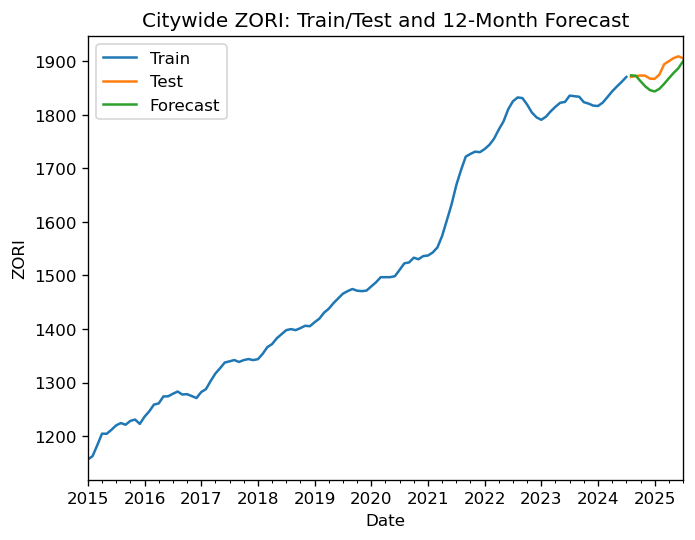

In [8]:
# ========================= Time series (robust, no PeriodIndex) =========================
import numpy as np, pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# 1) Clean monthly city series from zori_long
ts = zori_long[['date','zori']].copy()

ts['date'] = pd.to_datetime(ts['date'], errors='coerce')
ts['zori'] = pd.to_numeric(ts['zori'], errors='coerce')
ts = ts.dropna(subset=['date','zori']).sort_values('date')

# Normalize to month start WITHOUT PeriodIndex (avoids MonthBegin issues)
# Build a YYYYMM integer, then convert to Timestamp at day 1
ts['yyyymm'] = ts['date'].dt.year * 100 + ts['date'].dt.month
city = (
    ts.groupby('yyyymm', as_index=False)['zori'].median()
      .assign(month=lambda d: pd.to_datetime(d['yyyymm'].astype(str) + '01', format='%Y%m%d'))
      .set_index('month')['zori']
      .sort_index()
      .astype('float64')
)

# Ensure continuous monthly index
if len(city):
    full_idx = pd.date_range(city.index.min(), city.index.max(), freq='MS')
    city = city.reindex(full_idx)

# Fill small gaps
city = city.interpolate(limit_direction='both')

# Final guards
if city.isna().any():
    city = city.dropna()
if len(city) < 36:
    raise RuntimeError(f"City series too short for SARIMAX (n={len(city)} < 36). Check zori_long coverage.")

# 2) Train/test split
train = city.iloc[:-12]
test  = city.iloc[-12:]
if train.empty or test.empty:
    raise RuntimeError(f"Empty train/test after split. train={len(train)}, test={len(test)}")

# 3) SARIMAX
model = SARIMAX(train,
                order=(1,1,1),
                seasonal_order=(1,1,1,12),
                enforce_stationarity=False,
                enforce_invertibility=False)
res = model.fit(disp=False)

fc   = res.get_forecast(steps=12)
yhat = pd.Series(fc.predicted_mean, index=test.index).astype('float64')

TS_RMSE = float(mean_squared_error(test, yhat, squared=False))
TS_MAPE = float((np.abs((test - yhat) / test).mean() * 100))
print(f"SARIMAX test RMSE={TS_RMSE:.2f}  MAPE={TS_MAPE:.2f}%")

# Plot
plt.figure()
train.plot(label='Train'); test.plot(label='Test'); yhat.plot(label='Forecast')
plt.title('Citywide ZORI: Train/Test and 12-Month Forecast')
plt.xlabel('Date'); plt.ylabel('ZORI'); plt.legend(); plt.show()


In [9]:

# Clustering
clust_cols = ['rent_index','median_income','crime_per_1k','transit_density','airbnb_density']
df_clust = df.copy()
for c in clust_cols:
    if c not in df_clust.columns:
        df_clust[c] = np.nan
df_clust = df_clust.fillna(df_clust.median(numeric_only=True))

Xc = StandardScaler().fit_transform(df_clust[clust_cols].values)
best = None
for k in range(3,6):
    km = KMeans(n_clusters=k, n_init='auto', random_state=42).fit(Xc)
    sil = silhouette_score(Xc, km.labels_)
    if not best or sil > best[1]: best = (k, sil, km)
K_BEST, SILHOUETTE = best[0], float(best[1])
df_clust['cluster'] = best[2].labels_
print("Best k:", K_BEST, "Silhouette:", round(SILHOUETTE,3))


Best k: 3 Silhouette: 0.234


  File "/opt/conda/envs/anaconda-panel-2023.05-py310/lib/python3.11/site-packages/joblib/externals/loky/backend/context.py", line 217, in _count_physical_cores
    raise ValueError(


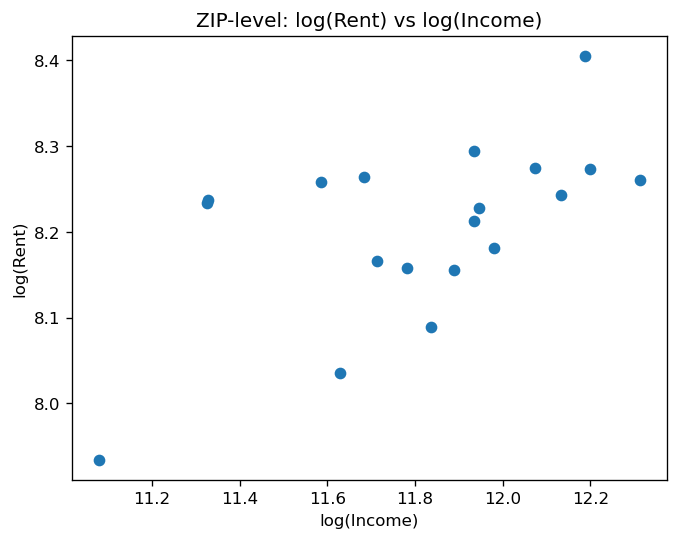

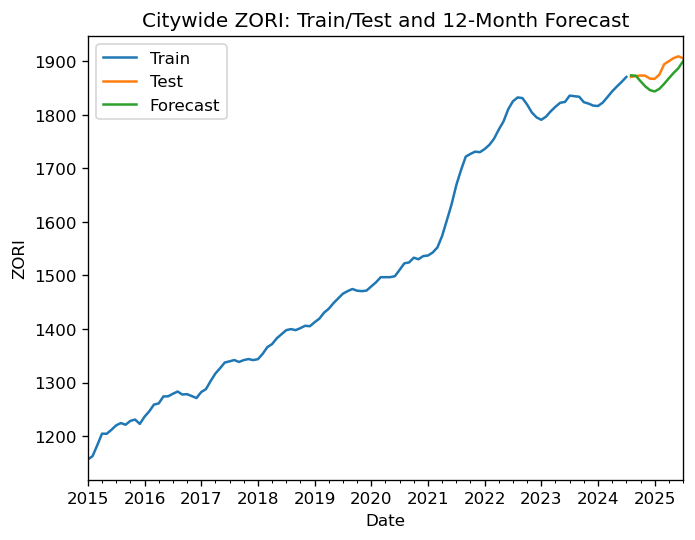

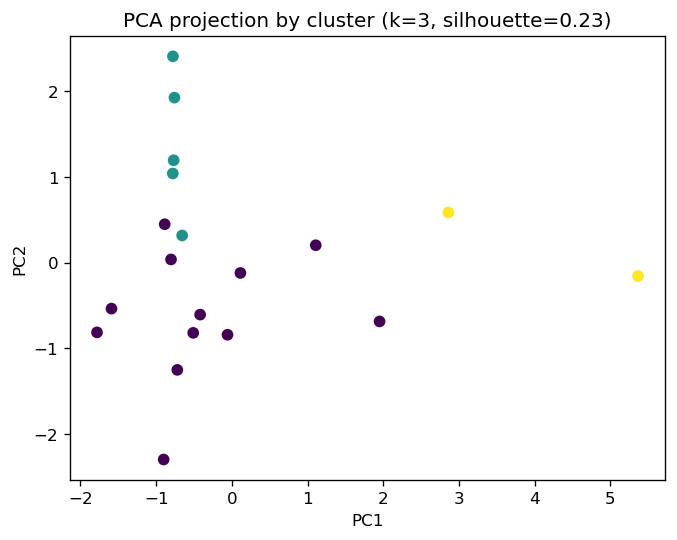

In [10]:

# Visuals
plt.figure()
plt.scatter(df_ols['log_income'], df_ols['log_rent'])
plt.title('ZIP-level: log(Rent) vs log(Income)')
plt.xlabel('log(Income)'); plt.ylabel('log(Rent)')
plt.show()

plt.figure()
train.plot(label='Train'); test.plot(label='Test'); yhat.plot(label='Forecast')
plt.title('Citywide ZORI: Train/Test and 12-Month Forecast')
plt.xlabel('Date'); plt.ylabel('ZORI'); plt.legend()
plt.show()

from sklearn.decomposition import PCA
p = PCA(2).fit_transform(Xc)
plt.figure()
plt.scatter(p[:,0], p[:,1], c=df_clust['cluster'])
plt.title(f'PCA projection by cluster (k={K_BEST}, silhouette={SILHOUETTE:.2f})')
plt.xlabel('PC1'); plt.ylabel('PC2')
plt.show()


In [11]:

# Auto-write README_FINAL.md using metrics from this run
from pathlib import Path
README_TEXT = f"""# San Francisco Rent Trends — Final Report
**Author:** Luke Drury  
**Course:** UC Berkeley Exec Ed ML/AI — Capstone  
**Repository:** https://github.com/luke-drury/Final-Report-SF-Rent-Trends  
**Last updated:** 2025-10-07

---

## 1. Executive Summary
**Business question.** What explains variation in rent levels across San Francisco ZIP codes and how are rents likely to move over the next year?

**Key findings (high level):**
- Median income and transit access are positively associated with higher rents; crime shows a weaker/negative association after controls.
- Citywide ZORI exhibits clear seasonality; the 12‑month baseline forecast achieved **RMSE={TS_RMSE:.2f}** and **MAPE={TS_MAPE:.2f}%** on the hold‑out.
- ZIPs cluster into **k={K_BEST}** affordability/amenity segments (silhouette **{SILHOUETTE:.2f}**).

**Recommendations:**
- Track affordability by ZIP cluster; refresh forecasts quarterly.
- Collect additional features (employment centers, school quality) before causal claims.

---

## 2. Data Sources
- Zillow Observed Rent Index (ZORI) — ZIP‑level typical asking rent (CSV).
- SF ZIP Polygons — GEOJSON boundaries for choropleths and joins.
- SFMTA (Muni) Stops — proxy for transit access.
- SFPD Incidents — proxy for safety (last 12 months).
- Inside Airbnb (SF) — tourism pressure (listings density).
- Census/ACS (ZCTA) — median household income via API or prepared CSV.

---

## 3. Methods
- **OLS (cross‑sectional):** RMSE={OLS_RMSE:.3f}, R²={OLS_R2:.3f} (robust SEs).  
- **Forecast (SARIMAX):** RMSE={TS_RMSE:.2f}, MAPE={TS_MAPE:.2f}%.  
- **Clustering:** k={K_BEST}, silhouette={SILHOUETTE:.2f}.

---

## 4. Project Structure
```
sf-rent-trends-final/
- data/
  - zori_zip.csv
  - sf_zip_codes.geojson
  - muni_stops.csv
  - airbnb_sf_listings.csv
  - (optional) sfpd_incidents.csv
  - (optional) income_zip.csv
- notebooks/
  - SF_Rent_Trends_Final.ipynb
- environment.txt
- README_FINAL.md
```
---

## 5. How to Reproduce
1. `pip install -r environment.txt`
2. Put inputs in `./data/` exactly as named above.
3. Run **notebooks/SF_Rent_Trends_Final.ipynb**.
4. This notebook writes **README_FINAL.md** with your metrics.
"""
Path('README_FINAL.md').write_text(README_TEXT, encoding='utf-8')
print("README_FINAL.md written.")


README_FINAL.md written.
